In [7]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jul 31 14:19:10 2021

@author: Smegn
"""

 #linear algebra and data processing
import numpy as np
import pandas as pd
import datetime

#visualisations
import seaborn as sb
import matplotlib.pyplot as plt
##
import mlflow
import mlflow.sklearn

# data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection

#ml
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# math and statistics
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# ignnore warnings
import warnings
warnings.filterwarnings(action="ignore")

In [8]:
#############Load Data################
train_data=pd.read_csv(r'C:\Users\Smegn\Documents\GitHub\Pharmaceutical-Sales-prediction-across-multiple-stores\data\train.csv')


test_data=pd.read_csv(r'C:\Users\Smegn\Documents\GitHub\Pharmaceutical-Sales-prediction-across-multiple-stores\data\test.csv')

store_data=pd.read_csv(r'C:\Users\Smegn\Documents\GitHub\Pharmaceutical-Sales-prediction-across-multiple-stores\data\store.csv')

sample_data=pd.read_csv(r'C:\Users\Smegn\Documents\GitHub\Pharmaceutical-Sales-prediction-across-multiple-stores\data\sample_submission.csv')

print('train set shape:', train_data.shape)
print('test set shape:', test_data.shape)
print('store set shape:', store_data.shape)

train set shape: (1017209, 9)
test set shape: (41088, 8)
store set shape: (1115, 10)


In [9]:
###Mising value##

'''6 of the store data columns contain missing values and one column of test data contain missing value.'''

#Function to calculate missing values by column
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # dtype of missing values
    mis_val_dtype = df.dtypes

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_dtype], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'Dtype'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns
missing_values_table(store_data)
missing_values_table(train_data)
missing_values_table(test_data)
###
'''
Before we deside to fill missing value we need to first merge both data sets with the store data
'''
# merge the train/test sets with the stores set
store_train = pd.merge(left = train_data, right = store_data, how = 'inner', left_on = 'Store', right_on = 'Store')
store_test = pd.merge(left = test_data, right = store_data, how = 'inner', left_on = 'Store', right_on = 'Store')
print(store_train.shape)
print(store_test.shape)
######Data Preprocessing###
#null values
store_train.isna().any()
store_test.isna().any()
###missing
missing_values_table(store_train)
missing_values_table(store_test)
####fill mising value
store_test['CompetitionDistance'].fillna(store_test['CompetitionDistance'].median(), inplace =True)
store_test.CompetitionOpenSinceMonth.fillna(0, inplace = True)
store_test.CompetitionOpenSinceYear.fillna(0,inplace=True)
store_test.Promo2SinceWeek.fillna(0, inplace = True)
store_test.Promo2SinceYear.fillna(0,inplace=True)
store_test.PromoInterval.fillna(0,inplace=True)
store_test.Open.fillna(0,inplace=True)
#fill mising value for store_train dataset
store_train['CompetitionDistance'].fillna(store_train['CompetitionDistance'].median(), inplace =True)
store_train.CompetitionOpenSinceMonth.fillna(0, inplace = True)
store_train.CompetitionOpenSinceYear.fillna(0,inplace=True)
store_train.Promo2SinceWeek.fillna(0, inplace = True)
store_train.Promo2SinceYear.fillna(0,inplace=True)
store_train.PromoInterval.fillna(0,inplace=True)
###check missing value###
missing_values_table(store_train)
missing_values_table(store_test)

#####function to plot
def plotvar(df, variable):
    plt.subplot(1,2,2)
    sb.boxplot(df[variable])
    plt.show()

Your selected dataframe has 10 columns.
There are 6 columns that have missing values.
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.
Your selected dataframe has 8 columns.
There are 1 columns that have missing values.
(1017209, 18)
(41088, 17)
Your selected dataframe has 18 columns.
There are 6 columns that have missing values.
Your selected dataframe has 17 columns.
There are 7 columns that have missing values.
Your selected dataframe has 18 columns.
There are 0 columns that have missing values.
Your selected dataframe has 17 columns.
There are 0 columns that have missing values.


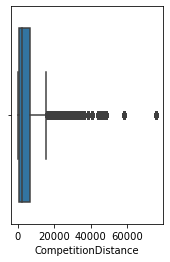

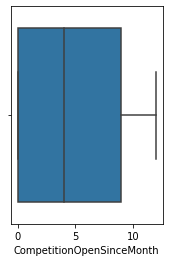

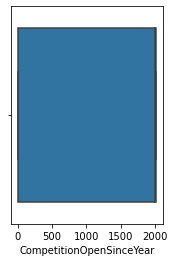

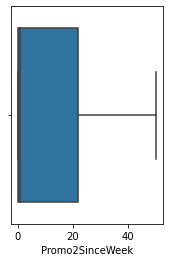

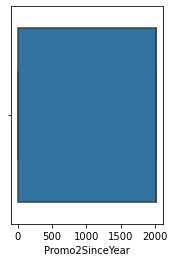

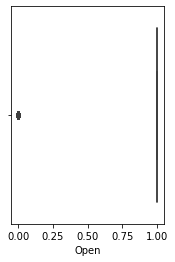

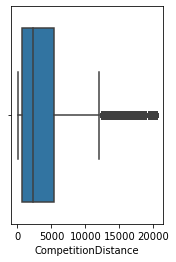

In [10]:
#outliers plot
plotvar(store_train,'CompetitionDistance')
plotvar(store_test,'CompetitionOpenSinceMonth')
plotvar(store_train,'CompetitionOpenSinceYear')
plotvar(store_train,'Promo2SinceWeek')
plotvar(store_train,'Promo2SinceYear')
plotvar(store_test,'Open')

####Fix outliers###
def fix_outlier(df, column):
    df[column] = np.where(df[column] > df[column].quantile(0.95), df[column].median(),df[column])
    
    return df[column]
#fix outliers
fix_outlier(store_train, 'CompetitionDistance')
fix_outlier(store_test, 'CompetitionDistance')
fix_outlier(store_train, 'Open')
fix_outlier(store_test, 'Open')
#plot after fixing outliers
plotvar(store_train,'CompetitionDistance')

#####extract new feature from the existing datetime columns  
#change date column to datetime
def feature_generation(data):
    data['Date'] = pd.to_datetime(data.Date)
    data['Month'] = data.Date.dt.month.to_list()
    data['Year'] = data.Date.dt.year.to_list()
    data['Day'] = data.Date.dt.day.to_list()
    data['WeekOfYear'] = data.Date.dt.weekofyear.to_list()
    data['DayOfWeek'] = data.Date.dt.dayofweek.to_list()
    data['weekday'] = 1 # Initialize the column with default value of 1
    data.loc[data['DayOfWeek'] == 5, 'weekday'] = 0
    data.loc[data['DayOfWeek'] == 6, 'weekday'] = 0
    data = data.drop(['Date'], axis = 1)
    return data

store_train_features=feature_generation(store_train)
store_test_features=feature_generation(store_test)

In [11]:
#identify weekends
store_train['is_weekend'] = ((pd.DatetimeIndex(store_train['Date']).dayofweek) // 5 == 1).astype(int)
store_train.head(14)
#Adding salespercustomer column
store_train['SalesperCustomer']=store_train['Sales']/store_train['Customers']
######
######
######
####Defining independent and dependent variables####
#######
store_train_features['SalesperCustomer']=store_train_features['Sales']/store_train_features['Customers']
#X = train_data.drop(['Customers', 'Sales', 'SalesperCustomer'], axis = 1)
store_train_features.corr()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Month,Year,Day,WeekOfYear,weekday,SalesperCustomer
Store,1.000000,-0.000008,0.005126,0.024325,-0.000047,0.000058,0.000641,-0.027875,-0.032893,-0.008794,0.008488,0.011053,0.008520,0.001467,0.000290,0.000023,0.001421,0.000005,-0.048423
DayOfWeek,-0.000008,1.000000,-0.462125,-0.386445,-0.528963,-0.392925,-0.205388,-0.000003,0.000008,0.000007,0.000168,0.000208,0.000168,-0.005362,0.001937,0.005136,-0.004880,-0.789894,-0.094924
Sales,0.005126,-0.462125,1.000000,0.894711,0.678472,0.452345,0.085124,-0.032997,-0.012431,0.002749,-0.091040,-0.044143,-0.091056,0.048768,0.023519,-0.011612,0.052946,0.450152,0.186581
Customers,0.024325,-0.386445,0.894711,1.000000,0.616768,0.316169,0.071568,-0.145971,-0.015188,0.000489,-0.150159,-0.098323,-0.150138,0.038179,-0.001212,-0.004473,0.041404,0.389334,-0.323898
Open,-0.000047,-0.528963,0.678472,0.616768,1.000000,0.295042,0.086171,-0.004020,-0.000200,-0.001144,-0.008309,-0.007436,-0.008308,-0.000681,-0.001009,0.033428,0.004792,0.537427,NaN
Promo,0.000058,-0.392925,0.452345,0.316169,0.295042,1.000000,0.067483,0.000010,-0.000039,-0.000034,-0.000983,-0.001210,-0.000983,-0.011747,0.024300,-0.108325,0.000572,0.495330,0.280009
SchoolHoliday,0.000641,-0.205388,0.085124,0.071568,0.086171,0.067483,1.000000,-0.002319,-0.001688,-0.001801,-0.006909,-0.006679,-0.006912,0.103282,-0.036535,0.030538,0.071052,0.263140,0.013192
CompetitionDistance,-0.027875,-0.000003,-0.032997,-0.145971,-0.004020,0.000010,-0.002319,1.000000,-0.050129,-0.051137,-0.013930,-0.037011,-0.014018,0.000266,0.000052,0.000002,0.000258,0.000002,0.320005
CompetitionOpenSinceMonth,-0.032893,0.000008,-0.012431,-0.015188,-0.000200,-0.000039,-0.001688,-0.050129,1.000000,0.784968,-0.081027,-0.108546,-0.080952,-0.001037,-0.000203,-0.000012,-0.001004,-0.000005,-0.025767
CompetitionOpenSinceYear,-0.008794,0.000007,0.002749,0.000489,-0.001144,-0.000034,-0.001801,-0.051137,0.784968,1.000000,-0.097433,-0.124378,-0.097363,-0.000897,-0.000176,-0.000011,-0.000868,-0.000004,-0.030547


In [12]:
#SInce we want to predict store sales, the target/ dependent variable is sales. For features we
#remove all columns that are strongly correlated to sales. From correlation analysis, we see that
#\"customers\" and \"salespercustomer\" have a strong positive correlation with sale. There we do
#away with these columns.
X = store_train_features.drop(['Customers', 'Sales', 'SalesperCustomer','Open','Promo'], axis = 1)
y=store_train_features['Sales']
#Training and testing split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15)

In [13]:
####encode###
le = LabelEncoder()
le.fit(X_train['StoreType'].astype(str))
X_train['StoreType']= le.transform(X_train['StoreType'].astype(str))
###
le = LabelEncoder()
le.fit(X_train['Assortment'].astype(str))
X_train['Assortment']= le.transform(X_train['Assortment'].astype(str))

##
le = LabelEncoder()
le.fit(X_train['StateHoliday'].astype(str))
X_train['StateHoliday']= le.transform(X_train['StateHoliday'].astype(str))
##
le = LabelEncoder()
le.fit(X_train['PromoInterval'].astype(str))
X_train['PromoInterval']= le.transform(X_train['PromoInterval'].astype(str))
####
le = LabelEncoder()
le.fit(X_test['StoreType'].astype(str))
X_test['StoreType']= le.transform(X_test['StoreType'].astype(str))
###
le = LabelEncoder()
le.fit(X_test['Assortment'].astype(str))
X_test['Assortment']= le.transform(X_test['Assortment'].astype(str))
##
le = LabelEncoder()
le.fit(X_test['StateHoliday'].astype(str))
X_test['StateHoliday']= le.transform(X_test['StateHoliday'].astype(str))
##
##
le = LabelEncoder()
le.fit(X_test['PromoInterval'].astype(str))
X_test['PromoInterval']= le.transform(X_test['PromoInterval'].astype(str))
###

In [14]:
regressor = RandomForestRegressor(n_estimators=10, criterion='mse',random_state=0)
regressor.fit(X_train, y_train)
###predict###
#####################################33
y_pred = regressor.predict(X_test)
y_pred_l = pd.DataFrame(y_pred, columns=["sales prediction"])
print(y_pred_l.head())
y_test.head()

   sales prediction
0            7143.6
1            5196.4
2            4898.4
3            5257.2
4            6263.9


991178    6716
4941      5079
493413    4998
264865    4224
737476    6350
Name: Sales, dtype: int64

In [15]:
###
def rmspe(y, result):
    rmspe = np.sqrt(np.mean( (y - result)**2 ))
    return rmspe
RFR = RandomForestRegressor(n_estimators=10,  criterion='mse',  max_depth=5,  min_samples_split=2, 
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0,  max_features='auto',max_leaf_nodes=None, 
                                min_impurity_decrease=0.0,  min_impurity_split=None,  bootstrap=True, oob_score=False, n_jobs=4, random_state=31, 
                                verbose=0,  warm_start=False)

In [ ]:

#with mlflow.start_run
params = {'max_depth':(4,6,8,10,12,14,16,20),'n_estimators':(4,8,16,24,48,72,96,128),'min_samples_split':(2,4,6,8,10)}
#scoring_fnc = metrics.make_scorer(rmspe)
#the dimensionality is high, the number of combinations we have to search is enormous, using
#RandomizedSearchCV 
# is a better option then GridSearchCV
grid = model_selection.RandomizedSearchCV(estimator=RFR,param_distributions=params,cv=5,)
grid.fit(X_train, y_train)
###Test our RF on the validation set##


(array([4.0974e+04, 9.0956e+04, 5.8705e+04, 9.1970e+03, 2.3750e+03,
        9.0200e+02, 2.3600e+02, 6.8000e+01, 2.2000e+01, 7.0000e+00]),
 array([    0.        ,  3451.06377847,  6902.12755694, 10353.19133541,
        13804.25511388, 17255.31889235, 20706.38267081, 24157.44644928,
        27608.51022775, 31059.57400622, 34510.63778469]),
 <BarContainer object of 10 artists>)

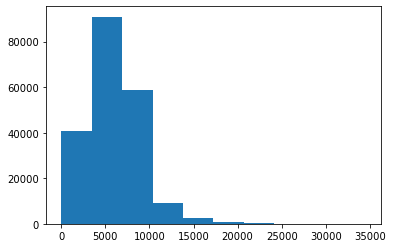

In [16]:
#with the optimal parameters i got let's see how it behaves with the validation set\n",
rfr_val=RandomForestRegressor(n_estimators=128,criterion='mse',  max_depth=20,min_samples_split=10,  min_samples_leaf=1,  min_weight_fraction_leaf=0.0,max_features='auto',max_leaf_nodes=None,min_impurity_decrease=0.0,min_impurity_split=None,bootstrap=True,oob_score=False, n_jobs=4,random_state=None, verbose=0,warm_start=False)
model_RF_test=rfr_val.fit(X_train,y_train)
result=model_RF_test.predict(X_test)
plt.hist(result)



In [17]:
#mean square error
mean_squared_error(y_test,result)


2052641.310682052

In [ ]:
##Predicting using XGBoost##
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.tree import  DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold

In [24]:
##XGB
xgbr = xgb.XGBRegressor(verbosity=0) 
print(xgbr)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)
       
xgbr.fit(X_train, y_train)
#After training the model, we'll check the model training score.

score = xgbr.score(X_train, y_train)  
print("Training score: ", score)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=0)
Training score:  0.8911102756702475


In [28]:
#We can also apply the cross-validation method to evaluate the training score.

scores = cross_val_score(xgbr,X_train, y_train,cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.89


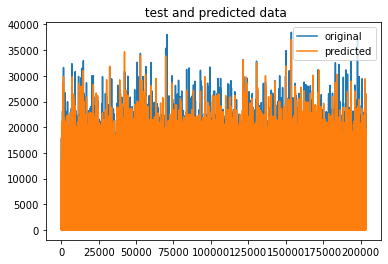

In [31]:
#visualize the original and predicted test data in a plot to compare visually.

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title(" test and predicted data")
plt.legend()
plt.show()

In [ ]:
##Decision Trees##
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)


In [ ]:

scores = cross_val_score(estimator = tree, X = X_train, y = y_train, cv = 5)
print(scores)
print("mean decision trees score : ", scores.mean())
# feature importance
feat_importance = tree.tree_.compute_feature_importances(normalize=False)
feat_imp_dict = dict(zip(X_train.columns, tree.feature_importances_))
feat_imp_1 = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp_1.rename(columns = {0:'FeatureImportance'}, inplace = True)
feat_imp_1.sort_values(by=['FeatureImportance'], ascending=False).head()
#visualize
plt.figure(figsize = (6,4))
sb.barplot(y = feat_imp_1.FeatureImportance, x = feat_imp_1.index)
plt.title('Feature Importances in Decision Trees')
plt.xticks(rotation = 45)
# using Decision Tree to run predictions on x_test
y_pred = tree.predict(X_test)
a = pd.DataFrame(y_pred)
a.columns = ['pred']
a.pred.value_counts()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler.fit(houseSales.Sales.values.reshape([-1, 1]))
houseSalesScaled = scaler.transform(houseSales.Sales.values.reshape(-1, 1))
houseSales['HouseSalesScaled'] = houseSalesScaled
houseSales.tail(10)

In [ ]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(store_train.Sales.index, store_train.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of pharmacy Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(store_train.Sales.index, store_train.Sales.SalesScaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled House Sales')
ax2.grid(True)
plt.show()